In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [454]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from bgspy.utils import load_pickle, mean_ratio
from bgspy.utils import center_and_scale, coefvar
from bgspy.plots import to_mb, get_figax, predicted_observed, smooth
from bgspy.optim import optim_diagnotics_plot

In [3]:
plt.show()

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

FIGDIR = '../manuscript/figures/'

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

## The Main Fits

There were numerous test fits along the way as the software was being developed, tested, and scaled. 

These however are the main for the paper.

In [ ]:
pops = ['yri', 'ceu', 'chb']

### Phastcons + CDS + genes


In [457]:
pcg = dict()
pcg_full = dict()
for pop in pops:
    pcg[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
    pcg_full[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes__decode//fits/pop_{pop}/window_1000000/type_full/mutrate_free/initial/mle.pkl')

In [412]:
for pop in pops:
    nll_sparse, nll_full = pcg[pop]['mbp'].nll_, pcg_full[pop]['mbp'].nll_
    print((pop, nll_sparse, nll_full, nll_full < nll_sparse))

('yri', 250657908564.79294, 250656989872.19766, True)
('ceu', 197826612684.87143, 197825873893.4953, True)
('chb', 61822016128.79776, 61821783504.67356, True)


(<Figure size 1600x800 with 6 Axes>,
 array([<Axes: ylabel='CDS'>, <Axes: ylabel='gene'>,
        <Axes: ylabel='other'>, <Axes: ylabel='phastcons'>,
        <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

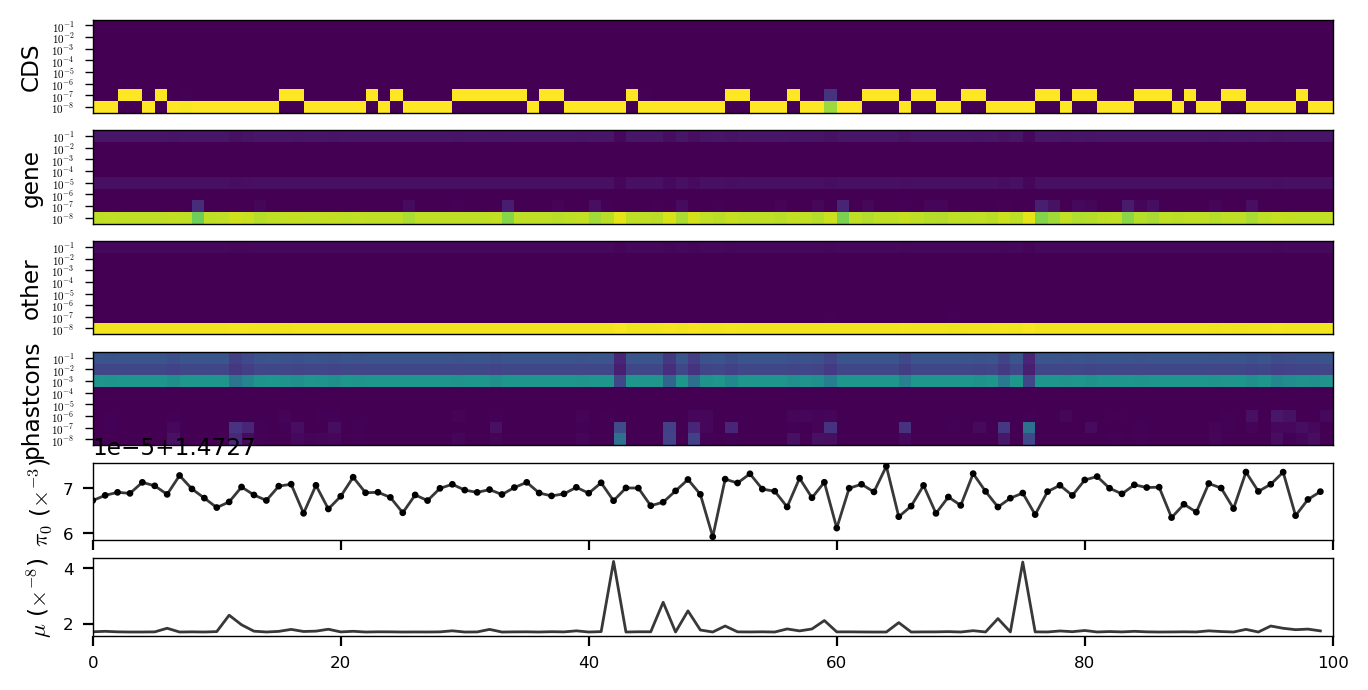

In [460]:
optim_diagnotics_plot(pcg_full['yri']['mbp'])

### Coefficient of Variation in Fits

The coefficient of variation of the predicted landscape is a function of spatial recombination and segments. Larger predictived CVs are determined by this.

In [399]:
cvs = dict()
for pop in pops:
    cvs[pop] = pcg[pop]['mbp'].coefvar()

Text(0.55, 0.15, 'Correlation: 0.75')

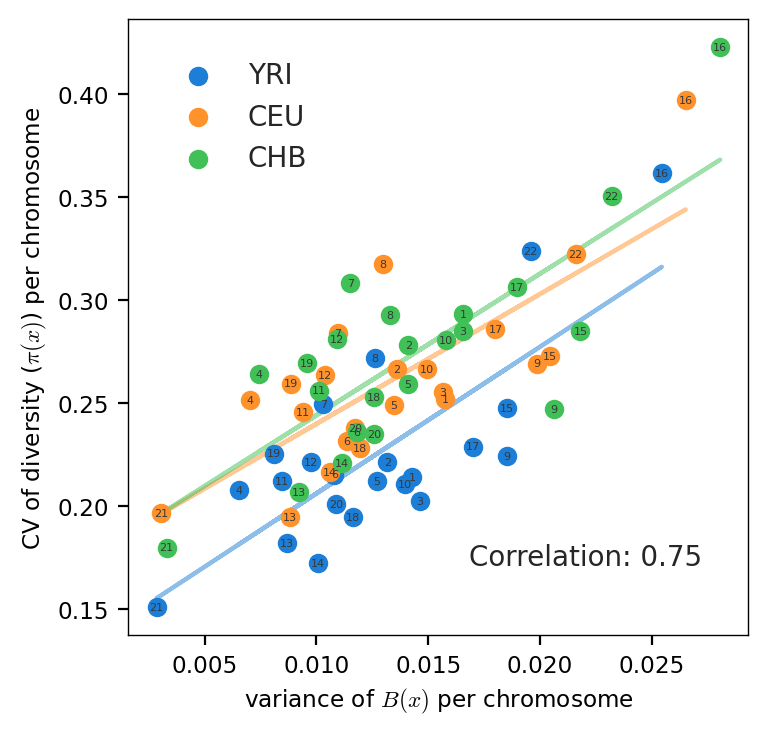

In [400]:
import matplotlib.patheffects as PathEffects
fig, ax = plt.subplots(figsize=(4, 4))
x, y = [], []


for pop in pops:
    d, p = list(cvs[pop][0].values()), list(cvs[pop][1].values())
    x.extend(d)
    y.extend(p)
    scatter = ax.scatter(p, d, label=pop.upper())
    for i, chrom in enumerate(cvs[pop][0].keys()):
        pass
        txt = ax.annotate(chrom.replace('chr', ''), xy=(p[i], d[i]), fontsize=4, color='0.22', va='center', ha='center')
        #txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='0.22')])
    m, b, *a = stats.linregress(p, d)
    ax.plot(p, [m * xi + b for xi in p], color=scatter.get_facecolor()[0], alpha=0.5, zorder=-10)

ax.set_xlabel('variance of $B(x)$ per chromosome')
ax.set_ylabel('CV of diversity ($\pi(x)$) per chromosome')
#ax.axline((0.05, 0.05), slope=1, c='0.22')
ax.legend(ncol=1)

cc = np.corrcoef(x, y)[0, 1]
ax.text(
    
    0.55,
    0.15,
    f"Correlation: {cc:.2f}",
    transform=ax.transAxes,
    verticalalignment="top",
)

In [105]:
stats.linregress(p, d).rvalue**2

0.5606841030998159

This is a version for talks, etc to show that populations do not have specific fits.

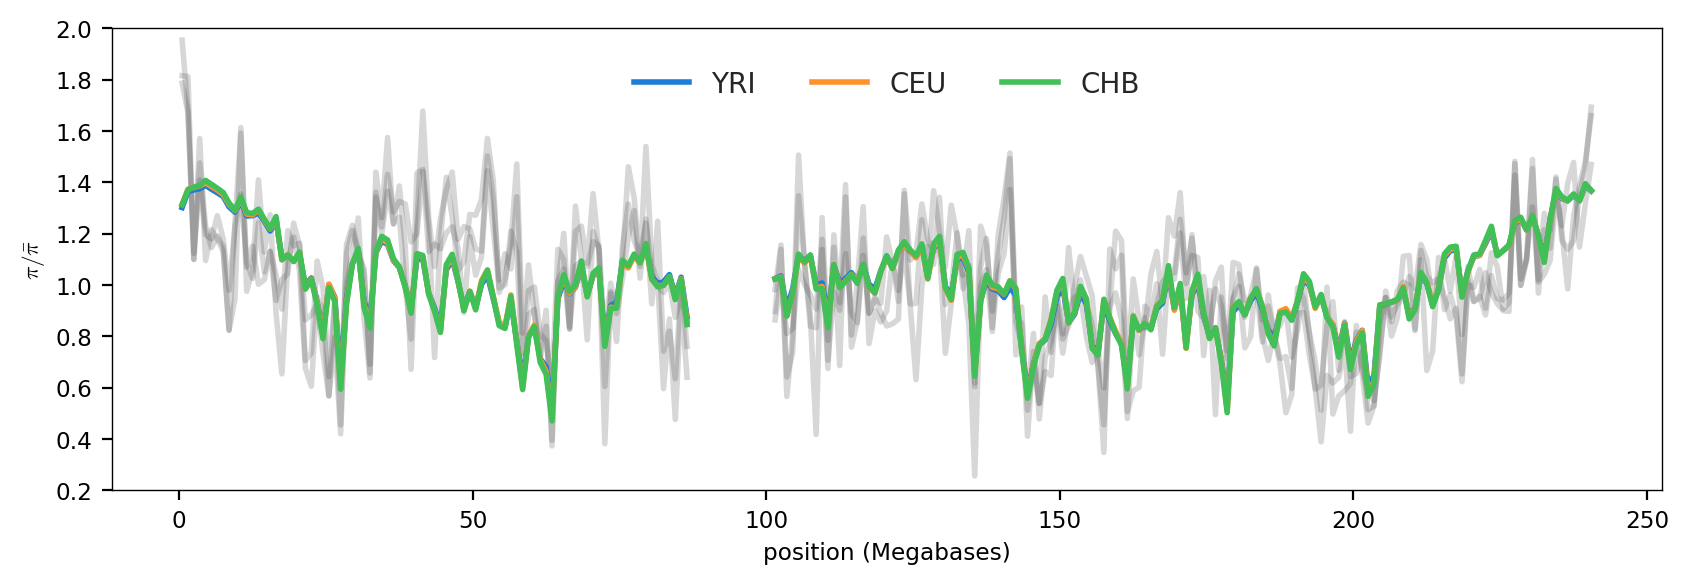

In [462]:
chrom = 'chr2'
cols = sns.color_palette()
    
figax = plt.subplots(figsize=(10, 3))
fig, ax = figax
pis = []
ax.set_ylim(0.2, 2)
for i, pop in enumerate(pops):
    fit = pcg[pop]['mbp']
    midpoints, pi = fit.bins.pi_pairs(chrom)
    pis.append(pi)
    fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())
    

    ax.legend()
    old_handles, old_labels = ax.get_legend_handles_labels()

    handles, labels = [], []
    for h, l in zip(old_handles, old_labels):
        if l == 'data':
            continue
        h.set_linewidth(2)
        handles.append(h)
        labels.append(l)
    ax.legend(handles, labels, ncols=4, loc='upper center')
    ax.set_xlabel("position (Megabases)")
    
    plt.savefig(f"../manuscript/figures/supplementary/talks/phastcons_model_fits_{i}.pdf")

/tmp/ipykernel_57287/321755458.py:19: RuntimeWarning: Mean of empty slice
  ax.plot(to_mb(midpoints), mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')


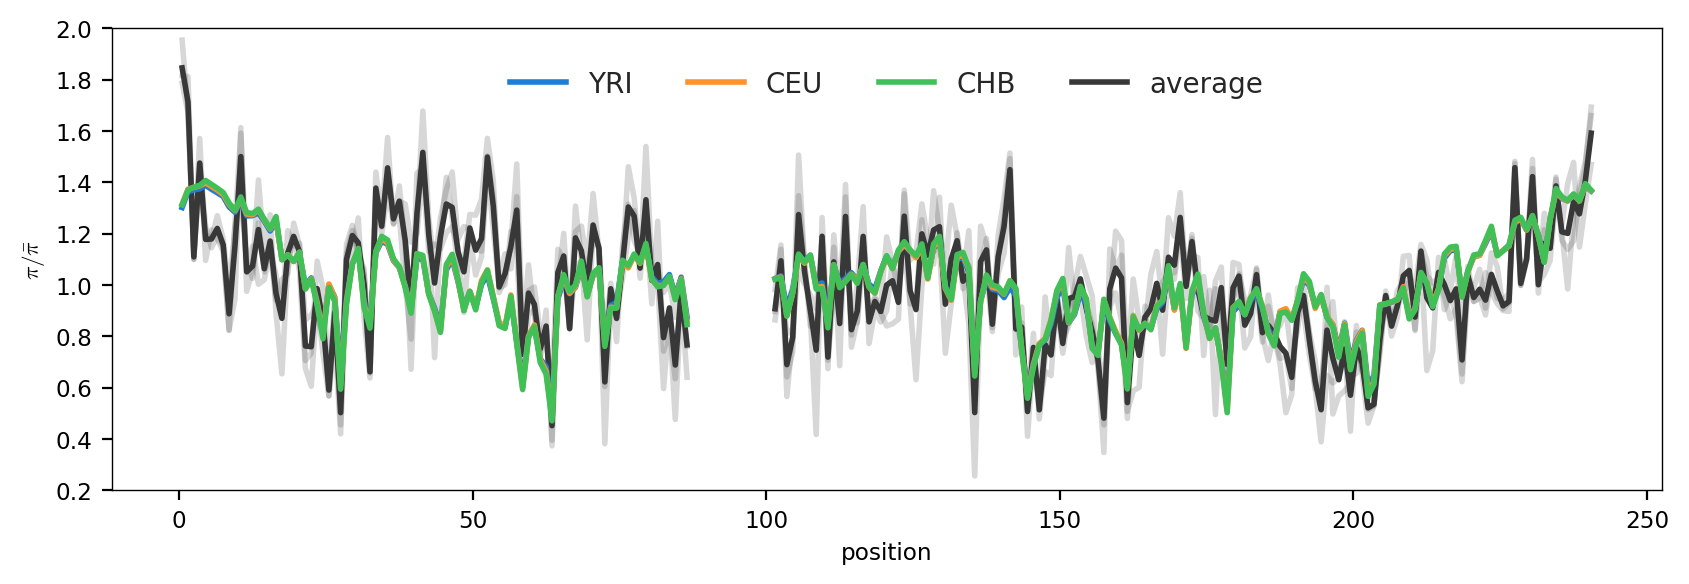

In [465]:
chrom = 'chr2'

def joint_prediction_plot(fits, chrom, pops=None, 
                          figax_kwargs=dict(figsize=(10, 3)), figax=None):
    if pops is None:
        pops = fits.keys()
    if isinstance(pops, str):
        pops = [pops]
    figax = get_figax(figax, **figax_kwargs)
    cols = sns.color_palette()
    fig, ax = figax
    pis = []
    for i, pop in enumerate(pops):
        fit = fits[pop]['mbp']
        midpoints, pi = fit.bins.pi_pairs(chrom)
        pis.append(pi)
        fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())

    ax.plot(to_mb(midpoints), mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')
    old_handles, old_labels = ax.get_legend_handles_labels()

    handles, labels = [], []
    for h, l in zip(old_handles, old_labels):
        if l == 'data':
            continue
        h.set_linewidth(2)
        handles.append(h)
        labels.append(l)
    ax.legend(handles, labels, ncols=4, loc='upper center')
    return fig, ax

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylim(0.2, 2)
joint_prediction_plot(pcg, 'chr2', figax=(fig, ax))
plt.savefig(f"../manuscript/figures/supplementary/talks/phastcons_model_fits_all.pdf")

In [470]:
{k: f['mbp'].R2() for k, f in pcg.items()}

{'yri': 0.6815821976013484,
 'ceu': 0.6301522801539102,
 'chb': 0.6108036144484064}

### CADD8

In [402]:
cd8 = dict()
cd8_full = dict()
cd8_rescale = dict()
for pop in pops:
    cd8[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
    cd8_full[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_full/mutrate_free/initial/mle.pkl')
    cd8_rescale[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/rescaled/mle.pkl')

In [318]:
pop = 'yri'
cd8[pop]['mbp'], cd8_rescale[pop]['mbp']

(SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250673972070.93787
 number of successful starts: 10000 (100.0% total)
 π0 = 0.00141668
 π  = 0.00106447
 μ_del  = 1.569e-08 
 Ne = 35,416 (if μ=1e-8), Ne = 17,708 (if μ=2e-8)
 R² = 67.0084% (in-sample)
 W = 
           cadd8
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.059
 0.001     0.298
 0.01      0
 0.1       0.643,
 SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 25064

Text(0.5, 0, 'predicted $B$')

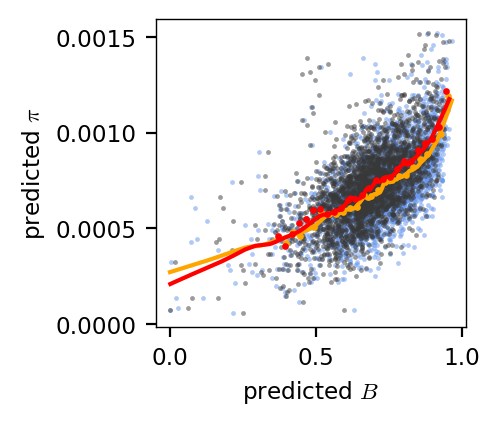

In [482]:
use_B = True
pop = 'chb'
fig, ax = plt.subplots(figsize=(2, 2))
predicted_observed(cd8[pop]['mbp'], figax=(fig, ax), use_B=use_B, c='cornflowerblue')
predicted_observed(cd8_rescale[pop]['mbp'], figax=(fig, ax), use_B=use_B, smooth_col='r', n_bins=40)
ax.set_ylabel('predicted $\pi$')
ax.set_xlabel('predicted $B$')
#ax.set_xlim((0.00025, 0.00105))
#ax.set_ylim((0.00019, 0.0016))

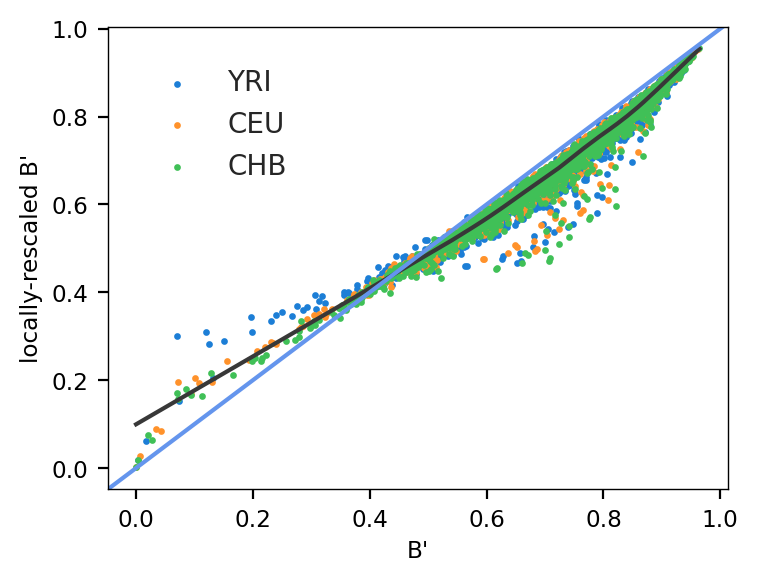

In [453]:
fig, ax = plt.subplots(figsize=(4, 3))
x, y = [], []
for pop in pops:
    ax.scatter(cd8[pop]['mbp'].predict(B=True), cd8_rescale[pop]['mbp'].predict(B=True), label=pop.upper(), s=2, alpha=1)
    x.extend(cd8[pop]['mbp'].predict(B=True))
    y.extend(cd8_rescale[pop]['mbp'].predict(B=True))


ax.plot(*smooth(x, y, frac=0.2), c='0.22')
ax.axline((0, 0), slope=1, c='cornflowerblue')
ax.set_ylabel("locally-rescaled B'")
ax.set_xlabel("B'")
ax.legend()

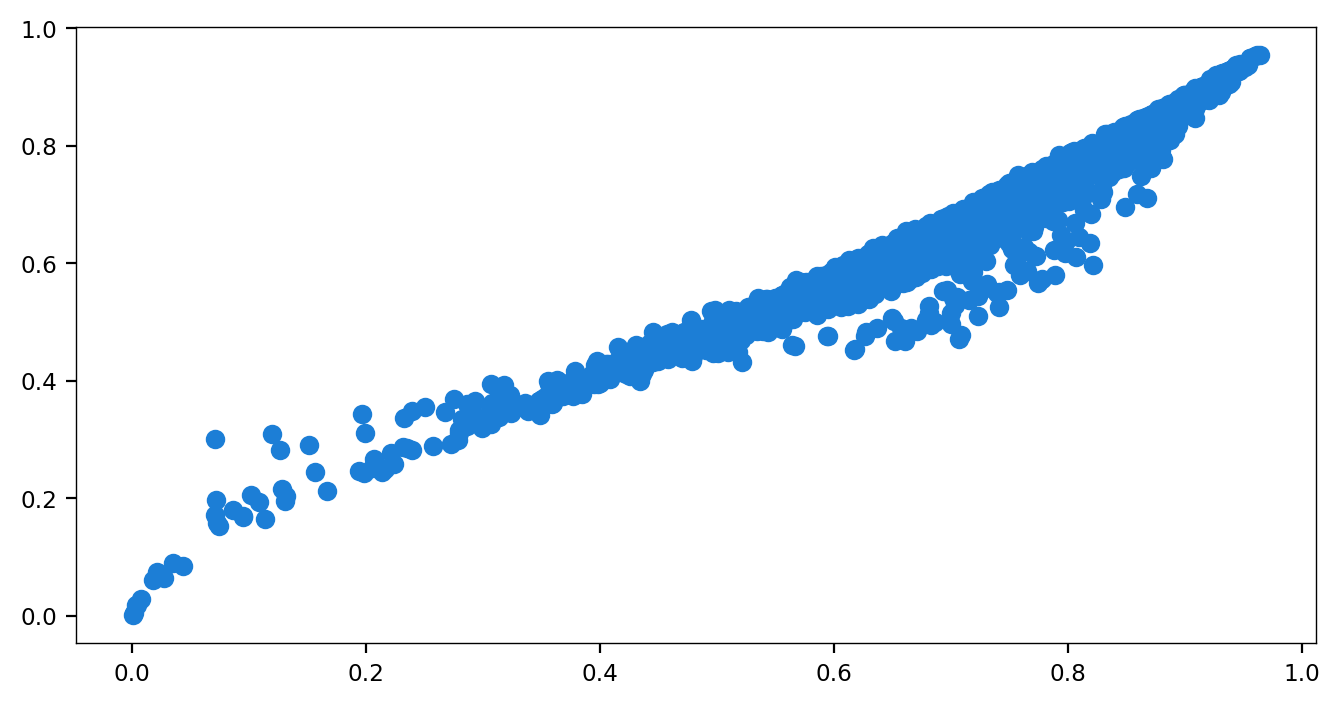

In [450]:
plt.scatter(x, y)

This change is interesting —  I think the HRI-type effects could be tipping the scales right around $Ns \approx 1$. 

First, things could be sensitive to my initial choice of neutral $N_e = 10,000$. What is the drift $N_e$ implied by this data?

In [395]:

for pop in pops:
    print((pop, cd8[pop]['mbp'].mle_pi0 / (4 * 1.3e-8)))

('yri', 27243.81489682956)
('ceu', 20587.968203528977)
('chb', 19345.549940170826)


So approximately, $20,000$ for bottlenecked pops, and ~27,000 for YRI.

Text(0.5, 0, '$B_r(x) - B(x)$')

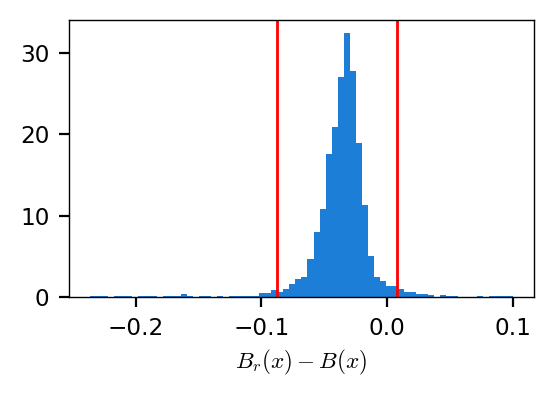

In [353]:
fig, ax = plt.subplots(figsize=(3, 1.8))
bins = cd8[pop]['mbp'].bins
b, br = cd8[pop]['mbp'].predict(B=True), cd8_rescale[pop]['mbp'].predict(B=True)
diff = br-b
_ = ax.hist(diff, 70, density=True)
cutoffs = np.quantile(diff, (0.02, 0.98))
ax.axvline(cutoffs[0], linewidth=1, c='r')
ax.axvline(cutoffs[1], linewidth=1, c='r')
ax.set_xlabel("$B_r(x) - B(x)$")

In [354]:
lower_idx = diff < cutoffs[0] 

In [361]:
#from bgspy.plots import predict_sparkplot
#predict_sparkplot(cd8[pop]['mbp'])

In [358]:
[bin for bin, keep in zip(bins.flat_bins(), lower_idx.tolist()) if keep]

[('chr1', 1000000, 2000000),
 ('chr1', 19000000, 20000000),
 ('chr1', 235000000, 236000000),
 ('chr2', 0, 1000000),
 ('chr2', 45000000, 46000000),
 ('chr2', 232000000, 233000000),
 ('chr3', 0, 1000000),
 ('chr4', 0, 1000000),
 ('chr4', 9000000, 10000000),
 ('chr5', 0, 1000000),
 ('chr5', 146000000, 147000000),
 ('chr5', 171000000, 172000000),
 ('chr5', 180000000, 181000000),
 ('chr6', 0, 1000000),
 ('chr7', 0, 1000000),
 ('chr7', 152000000, 153000000),
 ('chr8', 0, 1000000),
 ('chr8', 130000000, 131000000),
 ('chr8', 140000000, 141000000),
 ('chr9', 0, 1000000),
 ('chr9', 83000000, 84000000),
 ('chr10', 0, 1000000),
 ('chr11', 0, 1000000),
 ('chr11', 108000000, 109000000),
 ('chr11', 134000000, 135000000),
 ('chr12', 0, 1000000),
 ('chr12', 116000000, 117000000),
 ('chr12', 118000000, 119000000),
 ('chr12', 132000000, 133000000),
 ('chr13', 113000000, 114000000),
 ('chr14', 71000000, 72000000),
 ('chr15', 101000000, 101991189),
 ('chr16', 0, 1000000),
 ('chr16', 14000000, 15000000),
 (

### CADD6 

In [401]:
cd6 = dict()
for pop in pops:
    cd6[pop] = load_pickle(f'../new_fits/cadd6__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl') 

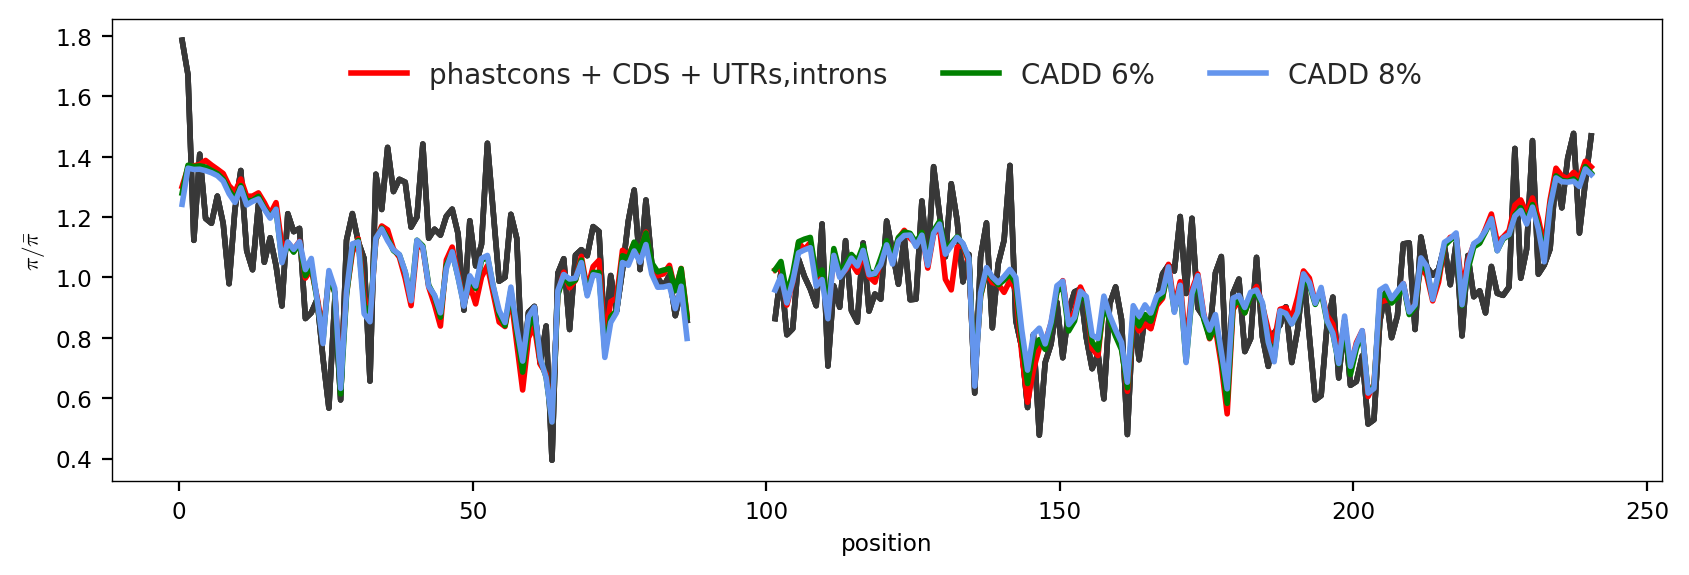

In [472]:
figax = plt.subplots(figsize=(10,3))
fig, ax = figax
pcg['yri']['mbp'].predict_plot('chr2', pred_col='r', figax=figax, label='phastcons + CDS + UTRs,introns')
#pcg_full['yri']['mbp'].predict_plot('chr2', pred_col='orange', figax=figax, label='phastcons + CDS + UTRs,introns')
cd6['yri']['mbp'].predict_plot('chr2', pred_col='g', figax=figax, label='CADD 6%')
cd8['yri']['mbp'].predict_plot('chr2', figax=figax, label='CADD 8%')
ax.legend(ncols=3)

old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

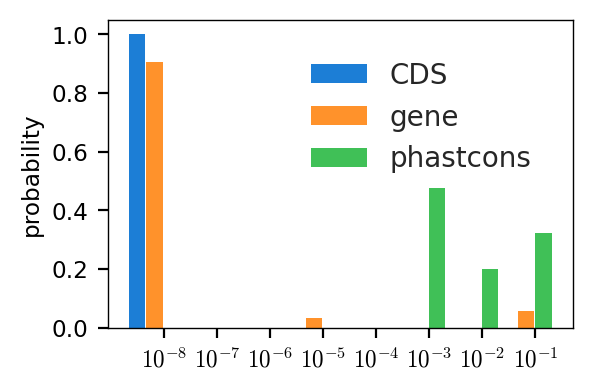

In [477]:
figax = plt.subplots(figsize=(3,2))
pcg['yri']['mbp'].dfe_plot(figax=figax)

In [478]:
def dfe_plot_alt(x_labels, groups, errors=None, keys=None, figax=None):
    fig, ax = get_figax(figax)
    nf = len(groups)
    x = np.arange(len(x_labels))
    
    width = 0.2  # the width of the bars
    mid_offset = -1
    multiplier = mid_offset

    bar_pos = []
    keys = groups.keys() if keys is None else keys
    for feature in keys:
        means = groups[feature]
        offset = width * multiplier
        pos = x + offset
        bar_pos.append(pos)
        rects = ax.bar(pos, means, width, label=feature.upper())
        if errors:
            ax.errorbar(pos, means, errors[feature], 
                        fmt='none', capsize=0, elinewidth=0.8, alpha=0.8, 
                        color='0.44')
        multiplier += 1
    
    ends = list(zip(bar_pos[0], bar_pos[-1]))    
    for i in range(len(x)):
        s, e = ends[i]
        #ax.plot((s-width/2, e+ width/2), (0, 0), c='k')

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_xticks(x + width, x_labels)
    ax.set_ylim(-0.001, None)
    

TypeError: unsupported operand type(s) for +: 'int' and 'SimplexModel'

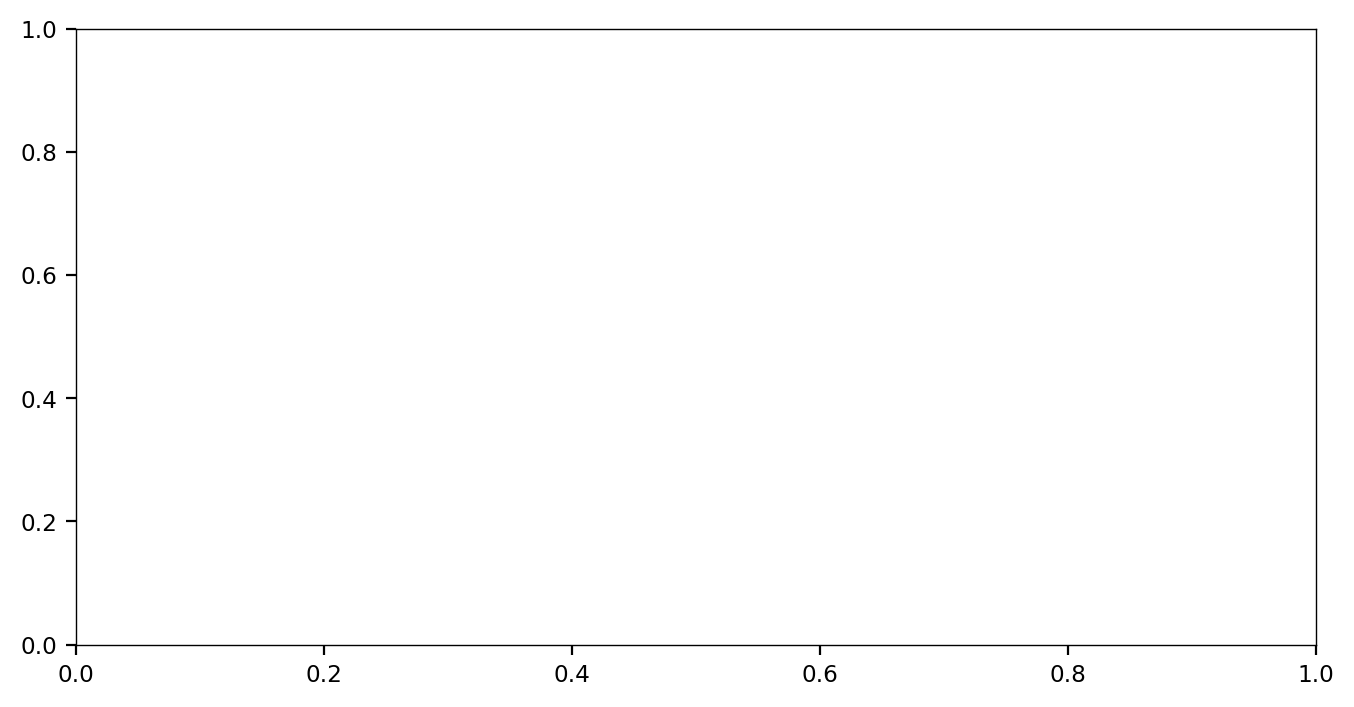

In [480]:
dfe_plot_alt(pcg['yri']['mbp'].t, {k: v['mbp'] for k, v in pcg.items()})

In [ ]:
dfes = defaultdict(lambda: defaultdict(dict))
dfe_errors = defaultdict(lambda: defaultdict(dict))

for model in fits:
    for pop in fits[model]:
        fit = fits[model][pop]
        res = fit.W_stderrs()
        if res is None:
            continue
        means, errors = res
        for feature in means:
            dfes[model][feature][pop] = means[feature]
            dfe_errors[model][feature][pop] = errors[feature]

In [ ]:
from bgspy.plots import get_figax

fit = fits['full-hapmap']['ceu']
means, errors = fit.W_stderrs()




fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'cds': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['full-hapmap']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes['full-hapmap'][feature], 
                 errors=dfe_errors['full-hapmap'][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

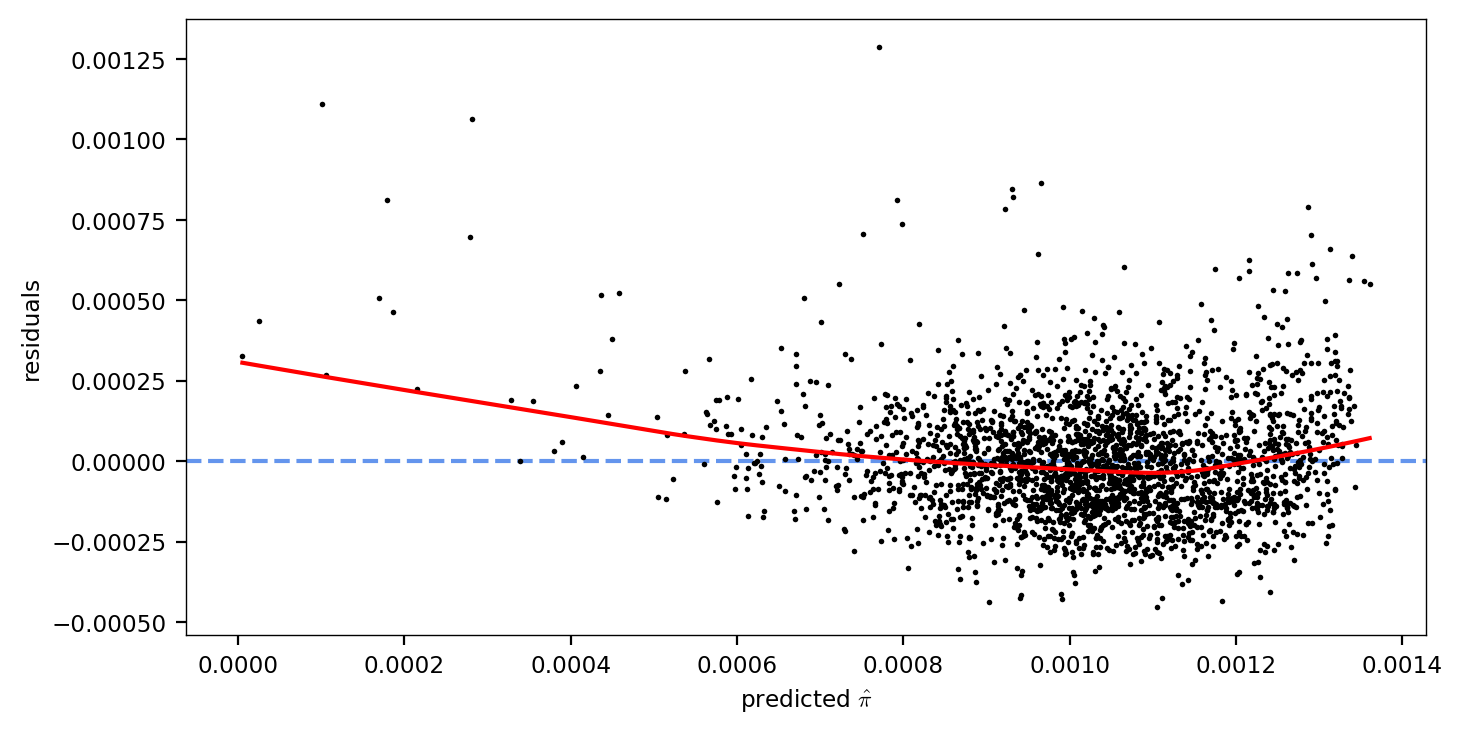

In [161]:
cd8['yri']['mbp'].resid_fitted_plot(color=False)


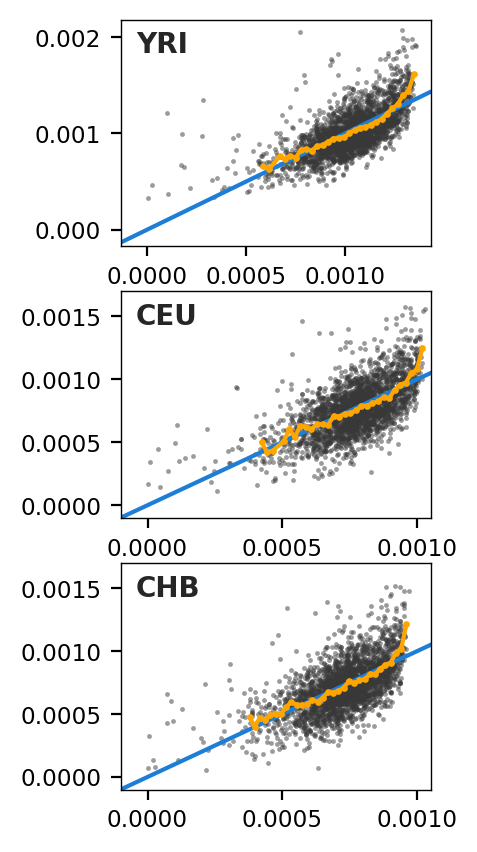

In [249]:
equal_num = False
smooth_col = 'orange'

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(2, 5))# sharex=True, sharey=True)
for i, pop in enumerate(pops):
    predicted_observed(cd8[pop]['mbp'], figax=(fig, ax[i])) 
    ax[i].text(0.05, 0.95, pop.upper(), transform=ax[i].transAxes, 
               fontsize=10, fontweight='bold', va='top')
    if i >= 1:
        ax[i].set_xlim((-1e-4, 0.00105))
        ax[i].set_ylim((-1e-4, 0.0017))

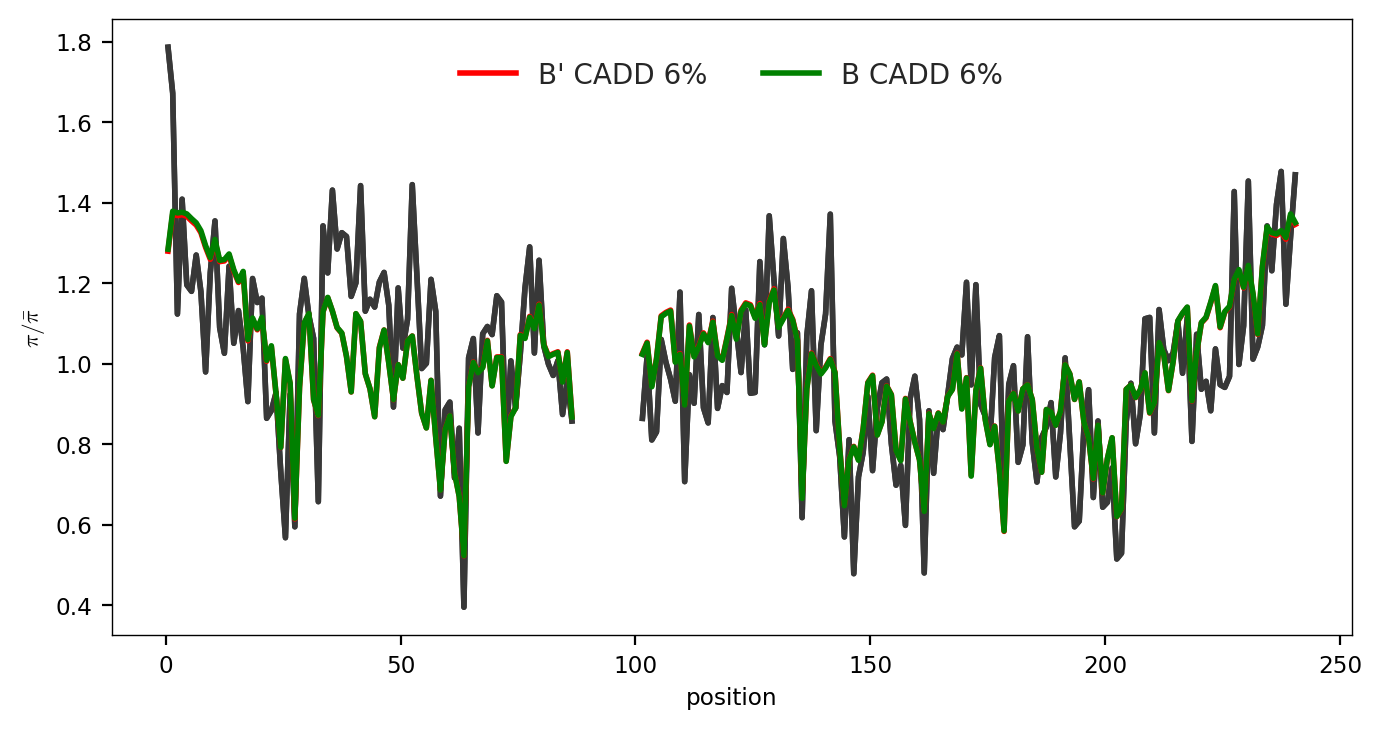

In [392]:
figax = plt.subplots()
fig, ax = figax
cd6['yri']['mbp'].predict_plot('chr2', pred_col='r', figax=figax, label="B' CADD 6%")
cd6['yri']['mb'].predict_plot('chr2', pred_col='g', figax=figax, label='B CADD 6%')
ax.legend(ncols=3)

old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

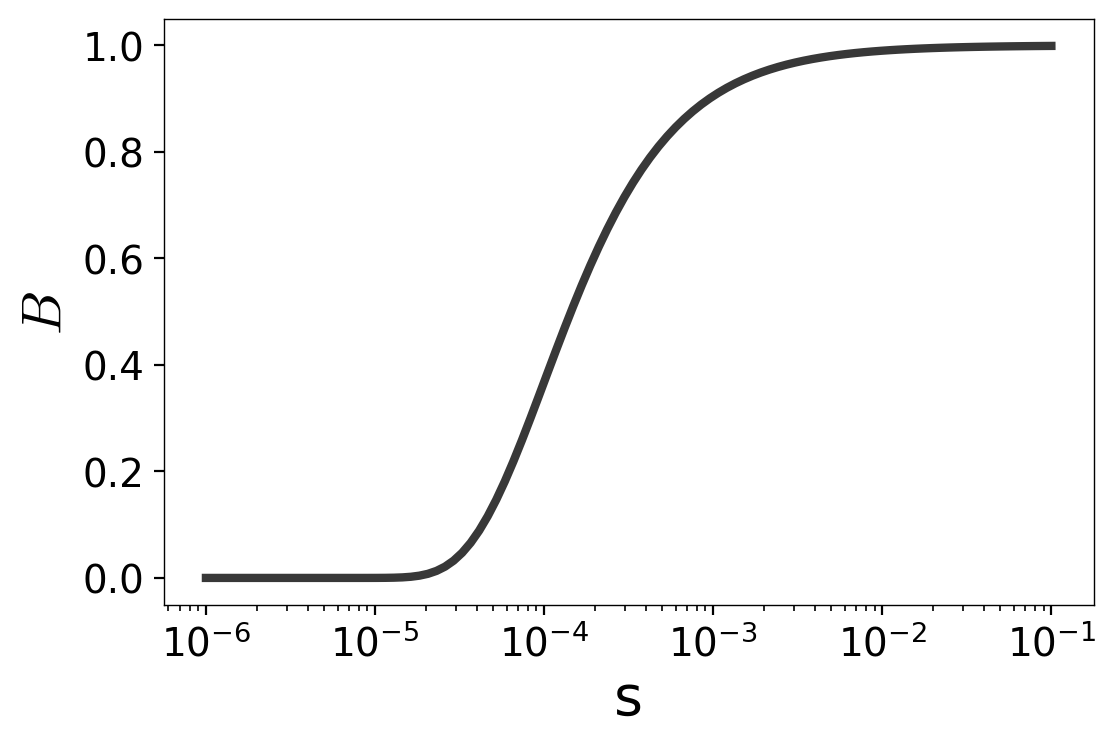

In [443]:
def bgs(s, u):
    return np.exp(-u/s)

fig, ax = plt.subplots(figsize=(6,3.8))
s = np.logspace(-6, -1, 100)
ax.plot(s, bgs(s, 1e-4), c='0.22', linewidth=3)
ax.semilogx()
ax.set_ylabel("$B$", fontsize=20)
ax.set_xlabel("s", fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=14)


In [425]:
np.exp(- 0.5 / s[-10:])

array([6.53986360e-07, 3.12266901e-06, 1.25586787e-05, 4.33516838e-05,
       1.30616156e-04, 3.48659775e-04, 8.35591405e-04, 1.81933466e-03,
       3.63691252e-03, 6.73794700e-03])

In [422]:
s

array([1.00000000e-06, 1.12332403e-06, 1.26185688e-06, 1.41747416e-06,
       1.59228279e-06, 1.78864953e-06, 2.00923300e-06, 2.25701972e-06,
       2.53536449e-06, 2.84803587e-06, 3.19926714e-06, 3.59381366e-06,
       4.03701726e-06, 4.53487851e-06, 5.09413801e-06, 5.72236766e-06,
       6.42807312e-06, 7.22080902e-06, 8.11130831e-06, 9.11162756e-06,
       1.02353102e-05, 1.14975700e-05, 1.29154967e-05, 1.45082878e-05,
       1.62975083e-05, 1.83073828e-05, 2.05651231e-05, 2.31012970e-05,
       2.59502421e-05, 2.91505306e-05, 3.27454916e-05, 3.67837977e-05,
       4.13201240e-05, 4.64158883e-05, 5.21400829e-05, 5.85702082e-05,
       6.57933225e-05, 7.39072203e-05, 8.30217568e-05, 9.32603347e-05,
       1.04761575e-04, 1.17681195e-04, 1.32194115e-04, 1.48496826e-04,
       1.66810054e-04, 1.87381742e-04, 2.10490414e-04, 2.36448941e-04,
       2.65608778e-04, 2.98364724e-04, 3.35160265e-04, 3.76493581e-04,
       4.22924287e-04, 4.75081016e-04, 5.33669923e-04, 5.99484250e-04,
      